In [835]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from numpy import pi,exp,sin,cos,arccos,arcsin,log10,sqrt,log
from numpy.random import exponential
import random



This notebook calculates the fluorescence emission from a TGF, which is initiated by an instantenous injection of $\gamma$-rays in fixed point in the amtosphere into a cone. 

It is possible to adjust the energy range of $\gamma$-rays and the direction of the cone

In [870]:
# Size of the Monte-Carlo sample
Nsamples=10000

# Number of generations of through which photon-electron evolution is traced
Ngen=20

# minimal and maximal energy of photons in the initial dN/dE~E^{-1} spectrum
E_gamma0=1e8
E_gamma1=1e6

# Gamma-ray injection altitude
H0=15.

# Photons are emitted in a cone with some opening angle, tilted to the vertical:
Opening_angle=30*pi/180.
Tilt=9*pi/180.

# Switch for electron or photon injection (1 is "ON")
PH_INJ=1
EL_INJ=0



# Sizes of images in XY and Z directions
Rmax=15
Hmax=30
Npixx=30
Npixz=30

#Earth magnetic field direction and strength
Zd_B=45.*pi/180.
DirX_B=sin(Zd_B)
DirY_B=0.
DirZ_B=cos(Zd_B)
B=1. # G
Dir_B=np.array([DirX_B,DirY_B,DirZ_B])

E_elec=0. # kV/cm in the direction of TGF
Hmin_elec=H0
Hmax_elec=H0+2.



$\gamma$-rays can interacxt via photoelectric effect, Compton scattering and Bethe-Heitler pair production. Here are the grammages for each process as a funciton of energy (found by analytical fitting):

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


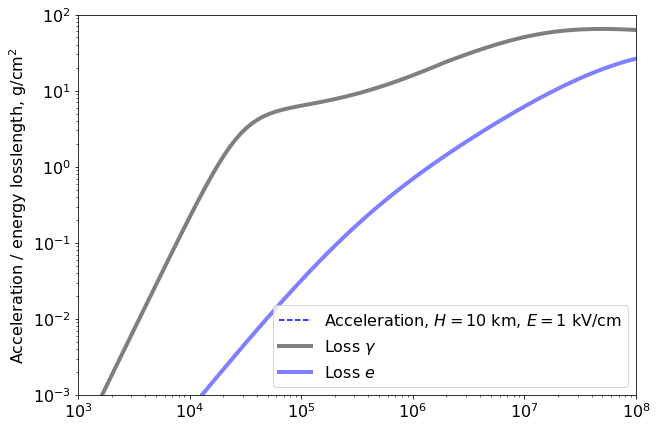

In [871]:
plt.figure(figsize=(10,7))
xx=np.logspace(3,8,100)

#gyroradius
R_L=0.02e5*1.2e-3*(xx/1e6)/(B/1.)
#plt.plot(xx,R_L)

plt.plot(xx,xx/(E_elec*1e3)*1.2e-3*exp(-10./8),color='blue',linestyle='dashed',label='Acceleration, $H=10$ km, $E=1$ kV/cm')

# Compton:
def grammage_Compton(E_gamma):
    return 5.16*(1+(E_gamma/0.25e6)**1)**(0.7/1.)
mfp_compton=grammage_Compton(xx)
#plt.plot(xx,mfp_compton,color='black',linestyle='solid')

# Photoelectric effect:
def grammage_photoel(E_gamma):
    return 3e2*(E_gamma/0.11e6)**3
mfp_photoel=grammage_photoel(xx)
#plt.plot(xx,mfp_photoel,color='black',linestyle='dashed')

# Pair produciton:
def grammage_BHpp(E_gamma):
    return (E_gamma>2.e6)*3e-1/(1-(2.e6/E_gamma)**0.001)+(E_gamma<2.e6)*1e6
mfp_BHpp=grammage_BHpp(xx)
#plt.plot(xx,mfp_BHpp,color='black',linestyle='dotted')

tot=1./(1/mfp_compton+1/mfp_photoel+1/mfp_BHpp)
plt.plot(xx,tot,color='black',linewidth=4,alpha=0.5,label=r'Loss $\gamma$')


# Ionisation loss for electrons:
def grammage_ionis(E_e):
    return 0.3*(E_e/0.3e6)**1.8/(1+(E_e/0.3e6))**0.9
mfp_ionis=grammage_ionis(xx)
#plt.plot(xx,mfp_ionis,color='blue',linestyle='solid')

# Bremsstrahlung loss for electrons:
def grammage_brems(E_e):
    return 50.*(E_e/1e8)**-0.1
mfp_brems=grammage_brems(xx)
#plt.plot(xx,mfp_brems,color='blue',linestyle='dashed')

tot_e=1./(1/mfp_ionis+1/mfp_brems)
plt.plot(xx,tot_e,color='blue',linewidth=4,alpha=0.5,label=r'Loss $e$')



plt.xscale('log')
plt.yscale('log')
plt.ylabel('Acceleration / energy losslength, g/cm$^2$',fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.ylim(1e-3,1e2)
plt.xlim(1e3,1e8)
plt.legend(loc='lower right',fontsize=16)

plt.savefig('Loss.png',format='png',dpi=100)



#electric field in thunderstorms can reach 1 kV per m. 
# the energy loss rate is 1e6 eV/ 10 m= 100 keV/m; we are at 1% level for minimal ionising particle.

Energy of the Compton-scattered photon:
$$
E'=\frac{E}{1+(E/m_e)(1-cos\theta)}
$$
Klein-Nishina cross-section of Compton scattering:
$$
\frac{d\sigma}{d\Omega dE'}=\frac{1}{2}r_0^2\left(\frac{E'}{E}\right)^2\left(\frac{E}{E'}+\frac{E'}{E}-\sin^2\theta\right)
$$
where $r_0$ is the classical radius of electron. The probability of scattering angle $\theta$ is
$$
p(\theta)\propto\left(\frac{E'}{E}\right)^2 \left(\frac{E}{E'}+\frac{E'}{E}-\sin^2\theta\right)\sin\theta
$$

In [872]:
# Energy of Compton-scattere photon as a function of initial energy E
def Ecomp(E,th):
    return E/(1+E/m_e*(1-cos(th)))

# Generator of Compton scattering angles, which takes into acccount the differential cross-section 
def compton_angle(E):
    x=pi*random.random() #trial scattering angle
    y=1.1*random.random()
    E1=E/(1+E/m_e*(1-cos(x)))
    yref=(E1/E)**2*(E/E1+E1/E-(sin(x))**2)*sin(x)
    while (y>yref):
        x=pi*random.random()
        y=1.1*random.random()
        E1=E/(1+E/m_e*(1-cos(x)))
        yref=(E1/E)**2*(E/E1+E1/E-(sin(x))**2)*sin(x)
    return x


THe fluorescence yield (for 0.85 MeV electron, as reported in https://arxiv.org/pdf/0801.4200.pdf) 3.2 photons per meter in the troposphere. The length of the track depends on the density, let's say, the energy loss rate is 2 MeV / cm in water (1g per cm3). 0.85 MeV electron would go for just 0.4 cm in water and 0.4e3 cm in the air in Troposphere. Overall it will emit 1200 photons. 

Each fluorescence photon has energy about 3 eV. This means that the overall fluorescence yield is 3.6 keV, or $4\times 10^{-3}$ of the electron energy. 

If we go to 24 km altitude, the fluorescence yield is 2.5 photons per m. But the density of the atmosphere is in fact  20 times smaller. Electron goes 20 times further, 8e3 cm. It will release 6e4 eV to the fluorescence, or 0.07 of its energy !

Density of atmosphere is 1.2e-3 g/cm3 at the ground level. it corresponds to the number density of electrons $\rho/(2m_p)\simeq 3.5\times 10^{20}$ cm$^{-3}$, since there is on average one electron per two nucleons. 

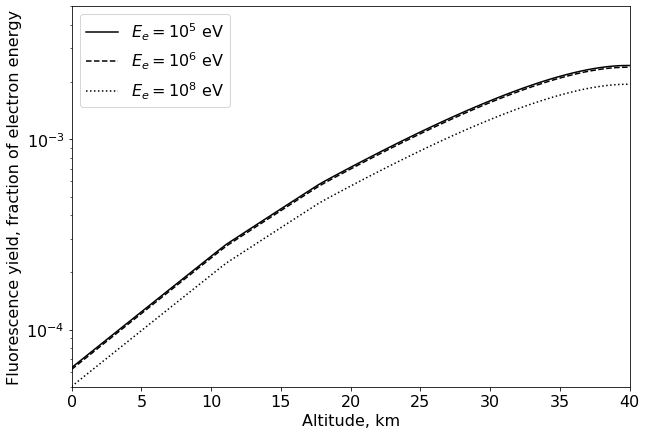

In [873]:
plt.figure(figsize=(10,7))

# density profile of the atmosphere. 
m_e=5.11e5
H_atm=8.
rho_atm=1.2e-3
n_atm0=3.5e20
def n_atm(H):
    return n_atm0*exp(-H/H_atm)

def rho_atm(H):
    return 1.2e-3*exp(-H/H_atm)


# Fluorescence yield in photons per m as a function of altitude, from arXiv:0801.4200
xx=np.linspace(0,50,100)
y=3.6+(xx<11.)*0.037*xx-((xx>11.))*(-0.41+0.06*(xx-11))-(xx>18.)*(-0.41+0.06*(xx-11))
#plt.plot(xx,y)

def fluo_yield(H,E):
    tmp=3.6+(H<11.)*0.037*H-((H>11.))*(-0.41+0.06*(H-11))-(H>18.)*(-0.41+0.06*(H-11)) #photons per m. 
    tmp1=tmp/1e2*grammage_ionis(E)/rho_atm(H)*3. # the last factor of 3 is the average energy of fluorescence photons
    return (tmp1>0.)*tmp1/E

plt.plot(xx,fluo_yield(xx,1e6),color='black',label=r'$E_e=10^5$ eV')
plt.plot(xx,fluo_yield(xx,1e7),color='black',linestyle='dashed',label=r'$E_e=10^6$ eV')
plt.plot(xx,fluo_yield(xx,1e8),color='black',linestyle='dotted',label=r'$E_e=10^8$ eV')


plt.yscale('log')
plt.ylabel('Fluorescence yield, fraction of electron energy',fontsize=16)
plt.xlabel('Altitude, km',fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.legend(loc='upper left',fontsize=16)
plt.ylim(5e-5,5e-3)
plt.xlim(0,40)
plt.savefig('Yield.png',format='png',dpi=100)
#plt.ylim(1e-3,1e0)



Next cell defines rotation matrix with rotation axis  $u=(u_x,u_y,u_z)$ for an angle $\alpha$:
$$
{\cal R}=\left(
\begin{array}{ccc}
\cos\theta+u_x^2(1-\cos\theta)&u_xu_y(1-\cos\theta)-u_z\sin\theta&u_x u_z(1-\cos\theta)+u_y\sin\theta\\
u_x u_y(1-\cos\theta)+u_z\sin\theta&\cos\theta+u_y^2(1-\cos\theta) & u_y u_z(1-\cos\theta)-u_x\sin\theta\\
u_z u_x(1-\cos\theta)-u_y\sin\theta&u_z u_y(1-\cos\theta)+u_x\sin\theta &\cos\theta+u_z^2(1-\cos\theta) \\
\end{array}
\right)
$$

In [874]:
# rotation matrix around an axis u for an angle theta:
def Rotation(u,theta):
    ux=u[0]
    uy=u[1]
    uz=u[2]
    cth=cos(theta)
    sth=sin(theta)
    res=np.zeros((3,3))
    res[0,0]=cth+ux**2*(1-cth)
    res[0,1]=ux*uy*(1-cth)-uz*sth
    res[0,2]=ux*uz*(1-cth)+uy*sth
    res[1,0]=ux*uy*(1-cth)+uz*sth
    res[1,1]=cth+uy**2*(1-cth)
    res[1,2]=uy*uz*(1-cth)-ux*sth
    res[2,0]=ux*uz*(1-cth)-uy*sth
    res[2,1]=uy*uz*(1-cth)+ux*sth
    res[2,2]=cth+uz**2*(1-cth)
    return res

#rotation of a vector v around an axis u for an angle theta:
def Rotate(u,theta,v):
    RR=Rotation(u,theta)
    res=np.zeros(3)
    for ii in range(3):
        for jj in range(3):
            res[ii]+=RR[ii,jj]*v[jj]
    return res


In [875]:
def Rotate_B(Dir,E,d):
    #Perpendicular component of magnetic field
    cB=Dir[0]*DirX_B+Dir[1]*DirY_B+Dir[2]*DirZ_B
    sB=sqrt(1-cB**2)
    #Giroradius is 0.02 km for E=1e6 and B=1e0; 
    theta=d*(B*sB)/(0.02*(E/1e6))
    return Rotate(Dir_B,theta,Dir)
                    

We want to model TGF fluorescence emission. We take a point source of gamma-ray photons with certain spectrum. Throw them randomly into a cone with given direction and opening angle. Then photons are Compton-scattered and pair produce. Energy is transferred to electrons, which dissipate it on Coulomb loss or Bremsstrtahlung. We compute what fraction is dissipated via Coulomb loss, this gives an estimate of the fluorescence signal. 

Next cell defines arrays for photon and electron energies, positions for each generation

In [876]:

nind=10 # reserved for furhter gammas and electrons
E_gamma=np.zeros((Nsamples,Ngen,nind))
E_e=np.zeros((Nsamples,Ngen,nind))
E_fluo=np.zeros((Nsamples,Ngen))    # energy in eV

# We first generate photons or electrons with dN/dE~E^{-1} powerlaw spectrum. We can re-weight the results for different spectra
log10_E=np.random.uniform(np.log10(E_gamma1),np.log10(E_gamma0),Nsamples)
E_inj=10**log10_E

Z_gamma=np.zeros((Nsamples,Ngen,nind))     # altitude in km
X_gamma=np.zeros((Nsamples,Ngen,nind))     # x position in km
Y_gamma=np.zeros((Nsamples,Ngen,nind))     # y position in km
T_gamma=np.zeros((Nsamples,Ngen,nind))     # time in seconds

Z_e=np.zeros((Nsamples,Ngen,nind))     # altitude in km
X_e=np.zeros((Nsamples,Ngen,nind))     # x position in km
Y_e=np.zeros((Nsamples,Ngen,nind))     # y position in km
T_e=np.zeros((Nsamples,Ngen,nind))     # time in seconds

cz = np.random.uniform(cos(Opening_angle),1,Nsamples)
Zd=arccos(cz)  # zenith angle in degrees
Az=np.random.uniform(0,2*pi,Nsamples)


DirX_gamma=np.zeros((Nsamples,Ngen,nind)) 
DirY_gamma=np.zeros((Nsamples,Ngen,nind)) 
DirZ_gamma=np.zeros((Nsamples,Ngen,nind)) 

DirX_e=np.zeros((Nsamples,Ngen,nind)) 
DirY_e=np.zeros((Nsamples,Ngen,nind)) 
DirZ_e=np.zeros((Nsamples,Ngen,nind)) 

# Flag indicates if a photon should be traced or it is taken out because it escaped or is absorbed
FLAG_gamma=np.ones((Nsamples,Ngen,nind))
FLAG_e=np.ones((Nsamples,Ngen,nind))
# Uncomment this for injection of photons
if PH_INJ==1:
    E_gamma[:,0,0]=E_inj
    Z_gamma[:,0,0]=H0*np.ones(Nsamples)
    nx=sin(Zd)*cos(Az)
    ny=sin(Zd)*sin(Az)
    nz=cos(Zd)
    for i in range(Nsamples):
        n=np.array([nx[i],ny[i],nz[i]])
        nn=Rotate(np.array([0,1,0]),Tilt,n)
        DirX_gamma[i,0,0]=nn[0]
        DirY_gamma[i,0,0]=nn[1]
        DirZ_gamma[i,0,0]=nn[2]
    for i in range(Nsamples):
            FLAG_gamma[i,0,0]=0
if EL_INJ==1:
    E_e[:,0,0]=E_inj
    Z_e[:,0,0]=H0*np.ones(Nsamples)
    nx=sin(Zd)*cos(Az)
    ny=sin(Zd)*sin(Az)
    nz=cos(Zd)
    for i in range(Nsamples):
        n=np.array([nx[i],ny[i],nz[i]])
        nn=Rotate(np.array([0,1,0]),Tilt,n)
        DirX_e[i,0,0]=nn[0]
        DirY_e[i,0,0]=nn[1]
        DirZ_e[i,0,0]=nn[2]
    for i in range(Nsamples):
            FLAG_e[i,0,0]=0






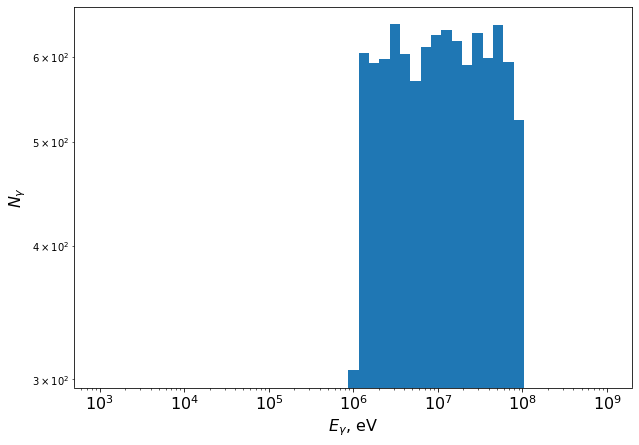

In [877]:
plt.figure(figsize=(10,7))

# Here is the photon spectrum
plt.hist(E_inj,bins=np.logspace(3,9,50))
plt.xscale('log')
plt.yscale('log')
plt.ylabel('$N_\gamma$',fontsize=16)
plt.xlabel('$E_\gamma$, eV',fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)


Next cell is the main evolution cycle. We move in each generation by the grammage drawn from exponential distributinons (for Compton scattering, pair produciton, ionisation and bremsstrahlung). To convert grammage $X$ into distance we will need the following formula
$$
X=\frac{1}{\cos\theta_z}\int_{h_1}^{h_2}\rho dh=\frac{\rho_0H}{\cos\theta_z}\left(e^{-h_1/H}-e^{-h_2/H}\right)
$$
$$
e^{-h_2/H}=e^{-h_1/H}-\frac{X\cos\theta_z}{\rho_0H}
$$
$$
h_2=-H\mbox{ln}\left(e^{-h_1/H}-\frac{X\cos\theta_z}{\rho_0H}\right)
$$
$$
d=\frac{h_2-h_1}{\cos\theta_z}=-\frac{1}{\cos\theta_z}\left(H\mbox{ln}\left(e^{-h_1/H}-\frac{X\cos\theta_z}{\rho_0H}\right)+h_1\right)
$$


In [878]:
# this is just to measure if we reach the maximum multiplication factor nind
kmax=0
# Total energy available at the beginning (we'll check energy conservation)
E_tot=sum(E_gamma[:,0,0])+sum(E_e[:,0,0])
E_tot_ionis=0.
E_tot_tgf=0.
E_tot_teb=0.


# We will store the fluorescence energy depositions:
E_FL=[]
X_FL=[]
Y_FL=[]
Z_FL=[]
T_FL=[]
im=np.zeros((Npixx,Npixz))
imxy=np.zeros((Npixx,Npixx))

# These arrays will store the TGF data
X_TGF=[]
Y_TGF=[]
Z_TGF=[]
E_TGF=[]
T_TGF=[]
im_gamma=np.zeros((Npixx,Npixz))
imxy_gamma=np.zeros((Npixx,Npixx))
E_tot_TGF=0.

# These arrays will store the TEB data
X_TEB=[]
Y_TEB=[]
Z_TEB=[]
E_TEB=[]
T_TEB=[]
im_teb=np.zeros((Npixx,Npixz))
imxy_teb=np.zeros((Npixx,Npixx))
E_tot_TEB=0.



# This is the main cycle. We move to each next generation, 
# calculating how much energy went to electrons, and chere does the scattered photon go
for gen in range(0,Ngen-1):
    print('Gen:',gen)
    print(sum(sum(E_e[:,gen,:]))/E_tot)
    print(sum(sum(E_gamma[:,gen,:]))/E_tot)
    print('Ionisation:',E_tot_ionis/E_tot)
    print('TGF:',E_tot_tgf/E_tot)
    print('TEB:',E_tot_teb/E_tot)
    print('All:',(sum(sum(E_e[:,gen,:]))+sum(sum(E_gamma[:,gen,:]))+E_tot_ionis+E_tot_tgf+E_tot_teb)/E_tot)


    # We first verify if after this step the photon will escape to infinity (i.e. if remaining grammage in
    # the atmosphere is smaller than expected grammage till next interaction)
    # we assume that total grammage at the ground level is 1e3 g/cm2. 
    # It dereases exponentially with altitude
    # DirZ is the cosine of the zenith angle
    for i in range(Nsamples):
        for k in range(nind):
            # In each generation, for each primary photon / electron, we go through all particles
            # whcih are still "alive" in the cascade and propagate them to the next step
            # we start from electrons:
            if(FLAG_e[i,gen,k]==0):                
                # here is the grammage which each electron will have to cross, before the next generation
                X_ionis=np.random.exponential(grammage_ionis(E_e[i,gen,k]))
                X_brems=np.random.exponential(grammage_brems(E_e[i,gen,k]))
                X=np.minimum(X_ionis,X_brems)
                
                # Electron can escape into TEB. This happens when the remaining
                # grammage in the atmosphere is smaller than the grammage
                # before next interaction
                if (X*DirZ_e[i,gen,k]>1e3*exp(-Z_e[i,gen,k]/H_atm)):
                    #print('... escaped')
                    #print('..Electron',i,k,'Coords',X_e[i,gen,k],Y_e[i,gen,k],Z_e[i,gen,k],'E=',E_e[i,gen,k]/1e6)

                    FLAG_e[i,gen+1,k]=1
                    E_tot_TEB+=E_e[i,gen,k]
                    E_TEB.append(E_e[i,gen,k])
                    X_TEB.append(X_e[i,gen,k])
                    Y_TEB.append(Y_e[i,gen,k])
                    Z_TEB.append(Z_e[i,gen,k])
                    T_TEB.append(T_e[i,gen,k])
                    E_tot_teb+=E_e[i,gen,k]
                    ii=int((X_e[i,gen,k]+Rmax)/(2.*Rmax)*Npixx)
                    iii=int((Y_e[i,gen,k]+Rmax)/(2.*Rmax)*Npixx)
                    jj=int(Z_e[i,gen,k]/Hmax*Npixz)
                    if(ii<Npixx)and(jj<Npixz)and(ii>0)and(jj>0):
                        im_teb[jj,ii]+=E_e[i,gen,k]
                    if(ii<Npixx)and(iii<Npixx)and(ii>0)and(iii>0):
                        imxy_teb[iii,ii]+=E_e[i,gen,k]

                # For ionisation, the electron just disappear (we set FLAG_e to 1) and fluorescence 
                # is added to the total fluorescence map
                else:
                    dist=-H_atm/DirZ_e[i,gen,k]*log(exp(-Z_e[i,gen,k]/H_atm)-X*DirZ_e[i,gen,k]/1e3)-Z_e[i,gen,k]/DirZ_e[i,gen,k]
                    #print('........ dist=',dist,exp(-Z_e[i,gen,k]/H_atm)-X*DirZ_e[i,gen,k]/1e3,Z_e[i,gen,k]/DirZ_e[i,gen,k])
                    X_e[i,gen+1,k]=X_e[i,gen,k]+dist*DirX_e[i,gen,k]
                    Y_e[i,gen+1,k]=Y_e[i,gen,k]+dist*DirY_e[i,gen,k]
                    Z_e[i,gen+1,k]=Z_e[i,gen,k]+dist*DirZ_e[i,gen,k]
                    T_e[i,gen+1,k]=T_e[i,gen,k]+dist/3.e5
                    
                    # Rotation in geomagnetic field
                    Dir=np.array([DirX_e[i,gen,k],DirY_e[i,gen,k],DirZ_e[i,gen,k]])
                    Dirr=Rotate_B(Dir,E_e[i,gen,k],dist)
                    DirX_e[i,gen+1,k]=Dirr[0]
                    DirY_e[i,gen+1,k]=Dirr[1]
                    DirZ_e[i,gen+1,k]=Dirr[2]
                    if Z_e[i,gen+1,k]<Hmax_elec:
                        dE=E_elec*1e3*(dist*1.e5)
                        #print('....acceleration:',Z_e[i,gen+1,k],E_e[i,gen,k]/1.e6,dist*1e5,E_elec*dist*1e5,dE/E_e[i,gen,k])
                    else: 
                        dE=0.


                    if (X_brems>X_ionis):
                        #print('...absorbed at',X_e[i,gen+1,k],Y_e[i,gen+1,k],Z_e[i,gen+1,k])

                        FLAG_e[i,gen+1,k]=0
                        E_e[i,gen+1,k]=(E_e[i,gen,k]+dE)/2.
                        #E_fluo=fluo_yield(Z_e[i,gen,k],E_e[i,gen,k]+dE)*(E_e[i,gen,k]+dE)
                        E_fluo=fluo_yield(Z_e[i,gen,k],E_e[i,gen,k])*(E_e[i,gen,k]+dE)/2.

                        #print('....',i,k,E_fluo)
                        E_FL.append(E_fluo)
                        T_FL.append(T_e[i,gen+1,k])
                        X_FL.append(X_e[i,gen+1,k])
                        Y_FL.append(Y_e[i,gen+1,k])
                        Z_FL.append(Z_e[i,gen+1,k])
                        E_tot_ionis+=(E_e[i,gen,k]+dE)/2.

                        # We update the image adding fluorescence energy output in the electron deposition point. 
                        ii=int((X_e[i,gen+1,k]+Rmax)/(2.*Rmax)*Npixx)
                        iii=int((Y_e[i,gen+1,k]+Rmax)/(2.*Rmax)*Npixx)
                        jj=int(Z_e[i,gen+1,k]/Hmax*Npixz)
                        if(ii<Npixx)and(jj<Npixz)and(ii>0)and(jj>0):
                            im[jj,ii]+=E_fluo
                        if(ii<Npixx)and(iii<Npixx)and(ii>0)and(iii>0):
                            imxy[iii,ii]+=E_fluo

                    # if next interaction is Bremsstahlung, we generate new photon, but leave electron 
                    # to the next generation:
                    else:
                        #print('...Bremsstrahlung at',X_e[i,gen+1,k],Y_e[i,gen+1,k],Z_e[i,gen+1,k])

                        # This is temporary solution, need to think how to split photons:
                        # Directions are also not right, gamma does not necessarily go along electron
                        FLAG_e[i,gen+1,k]=0

                        # here is how to find a "vacant cell" ii in the photon list for given generation (gen+1)
                        # and primary particle i :
                        ii=0
                        while (FLAG_gamma[i,gen,ii]==0)and(ii<nind-1):
                            ii+=1
                        FLAG_gamma[i,gen+1,ii]=0
                        if(ii>kmax):
                            kmax=ii

                        # we assume that Bremsstrahlung spectrum is dN/dE~E^{-1}:
                        frac=10**(random.uniform(-1,0))
                        E_gamma[i,gen+1,ii]=frac*(E_e[i,gen,k]+dE)
                        X_gamma[i,gen+1,ii]=X_e[i,gen+1,k]
                        Y_gamma[i,gen+1,ii]=Y_e[i,gen+1,k]
                        Z_gamma[i,gen+1,ii]=Z_e[i,gen+1,k]
                        T_gamma[i,gen+1,ii]=T_e[i,gen+1,k]
                        DirX_gamma[i,gen+1,ii]=DirX_e[i,gen,k]
                        DirY_gamma[i,gen+1,ii]=DirY_e[i,gen,k]
                        DirZ_gamma[i,gen+1,ii]=DirZ_e[i,gen,k]

                        E_e[i,gen+1,k]=(1-frac)*(E_e[i,gen,k]+dE)

            # Now we take all still active photons:
            if(FLAG_gamma[i,gen,k]==0):

                # here is the grammage which each gamma-ray will have to cross, before the next generation
                X_comp=np.random.exponential(grammage_Compton(E_gamma[i,gen,k]))
                X_pp=np.random.exponential(grammage_BHpp(E_gamma[i,gen,k]))
                X_photoel=np.random.exponential(grammage_photoel(E_gamma[i,gen,k]))
                X=np.minimum(X_comp,X_pp)
                X=np.minimum(X,X_photoel)

                # Photon can escape into TGF. This happens when the remaining
                # grammage in the atmosphere is smaller than the grammage
                # before next interaction
                if (X*DirZ_gamma[i,gen,k]>1e3*exp(-Z_gamma[i,gen,k]/H_atm)):
                    #print('... escaped')
                    #print('..Gamma',i,k,'Coords',X_gamma[i,gen,k],Y_gamma[i,gen,k],Z_gamma[i,gen,k],'E=',E_gamma[i,gen,k]/1e6)

                    FLAG_gamma[i,gen+1,k]=1
                    E_tot_TGF+=E_gamma[i,gen,k]
                    E_TGF.append(E_gamma[i,gen,k])
                    X_TGF.append(X_gamma[i,gen,k])
                    Y_TGF.append(Y_gamma[i,gen,k])
                    Z_TGF.append(Z_gamma[i,gen,k])
                    T_TGF.append(T_gamma[i,gen,k])
                    E_tot_tgf+=E_gamma[i,gen,k]
                    # We update the image adding fluorescence energy output in the electron deposition point. 
                    ii=int((X_gamma[i,gen,k]+Rmax)/(2.*Rmax)*Npixx)
                    iii=int((Y_gamma[i,gen,k]+Rmax)/(2.*Rmax)*Npixx)
                    jj=int(Z_gamma[i,gen,k]/Hmax*Npixz)
                    if(ii<Npixx)and(jj<Npixz)and(ii>0)and(jj>0):
                        im_gamma[jj,ii]+=E_gamma[i,gen,k]
                    if(ii<Npixx)and(iii<Npixx)and(ii>0)and(iii>0):
                        imxy_gamma[iii,ii]+=E_gamma[i,gen,k]

                else:
                    #the gamma-ray at this altitude will go for the distance:
                    dist=-H_atm/DirZ_gamma[i,gen,k]*log(exp(-Z_gamma[i,gen,k]/H_atm)-X*DirZ_gamma[i,gen,k]/1e3)-Z_gamma[i,gen,k]/DirZ_gamma[i,gen,k]

                    #its current direction is DirX, DirY, DirZ
                    #it will arrive at the position:
                    X_gamma[i,gen+1,k]=X_gamma[i,gen,k]+dist*DirX_gamma[i,gen,k]
                    Y_gamma[i,gen+1,k]=Y_gamma[i,gen,k]+dist*DirY_gamma[i,gen,k]
                    Z_gamma[i,gen+1,k]=Z_gamma[i,gen,k]+dist*DirZ_gamma[i,gen,k]
                    T_gamma[i,gen+1,k]=T_gamma[i,gen,k]+dist/3.e5



                    if(X==X_comp):
                        FLAG_gamma[i,gen+1,k]=0
                        #print('...Compton at',X_gamma[i,gen+1,k],Y_gamma[i,gen+1,k],Z_gamma[i,gen+1,k])
                        # For Compton scattering, we need to change the direction:
                        angle=compton_angle(E_gamma[i,gen,k])
                        # We need to change the direction of photon
                        # we do it by first rotating by scattering angle counter-clock-wise in vertical direction
                        # for which the rotation axis is horizontal and perpendicular to the vertical plane
                        u=np.array([-1.*DirX_gamma[i,gen,k],DirY_gamma[i,gen,k],0.])
                        n=np.array([DirX_gamma[i,gen,k],DirY_gamma[i,gen,k],DirZ_gamma[i,gen,k]])
                        tmp=Rotate(u,angle,n)
                        #Next, we rotate this intermediate vector by some arbitrary angle around the previous direction:
                        nn=Rotate(n,np.random.uniform(0,np.pi*2),tmp)
                        DirX_gamma[i,gen+1,k]=nn[0]
                        DirY_gamma[i,gen+1,k]=nn[1]
                        DirZ_gamma[i,gen+1,k]=nn[2]

                        # We re-calculate photon energies for the known scattering angles
                        E_gamma[i,gen+1,k]=Ecomp(E_gamma[i,gen,k],angle)
                        
                        # generate new energetic electron:
                        ii=0
                        while (FLAG_e[i,gen+1,ii]==0)and(ii<nind-1):
                            ii+=1
                        FLAG_e[i,gen+1,ii]=0
                        if(ii>kmax):
                            kmax=ii

                        # Electron recoil energies are the differences between the initial and final photon energies
                        E_e[i,gen+1,ii]=E_gamma[i,gen,k]-E_gamma[i,gen+1,k]
                        DirX_e[i,gen+1,ii]=-(E_gamma[i,gen+1,k]*DirX_gamma[i,gen,k]-E_gamma[i,gen,k]*DirX_gamma[i,gen,k])
                        DirY_e[i,gen+1,ii]=-(E_gamma[i,gen+1,k]*DirY_gamma[i,gen,k]-E_gamma[i,gen,k]*DirY_gamma[i,gen,k])
                        DirZ_e[i,gen+1,ii]=-(E_gamma[i,gen+1,k]*DirZ_gamma[i,gen,k]-E_gamma[i,gen,k]*DirZ_gamma[i,gen,k])
                        norm=sqrt(DirX_e[i,gen+1,ii]**2+DirY_e[i,gen+1,ii]**2+DirZ_e[i,gen+1,ii]**2)
                        DirX_e[i,gen+1,ii]=DirX_e[i,gen+1,ii]/norm
                        DirY_e[i,gen+1,ii]=DirY_e[i,gen+1,ii]/norm
                        DirZ_e[i,gen+1,ii]=DirZ_e[i,gen+1,ii]/norm
                        #if(DirZ_e[i,gen+1,ii]<0):
                        #    print('.....electron downwards')
                        X_e[i,gen+1,ii]=X_gamma[i,gen+1,k]
                        Y_e[i,gen+1,ii]=Y_gamma[i,gen+1,k]
                        Z_e[i,gen+1,ii]=Z_gamma[i,gen+1,k]
                        T_e[i,gen+1,ii]=T_gamma[i,gen+1,k]




                    elif(X==X_pp):
                        #print('...Pairs at',X_gamma[i,gen+1,k],Y_gamma[i,gen+1,k],Z_gamma[i,gen+1,k])

                        FLAG_gamma[i,gen+1,k]=1
                        ii=0
                        while (FLAG_e[i,gen+1,ii]==0)and(ii<nind-1):
                            ii+=1
                        FLAG_e[i,gen+1,ii]=0
                        iii=ii
                        while (FLAG_e[i,gen+1,iii]==0)and(iii<nind-1):
                            iii+=1
                        if(ii>kmax):
                            kmax=ii

                        FLAG_e[i,gen+1,iii]=0
                        E_e[i,gen+1,ii]=E_gamma[i,gen,k]/2.
                        E_e[i,gen+1,iii]=E_gamma[i,gen,k]/2.
                        DirX_e[i,gen+1,ii]=DirX_gamma[i,gen,k]
                        DirX_e[i,gen+1,iii]=DirX_gamma[i,gen,k]
                        DirY_e[i,gen+1,ii]=DirY_gamma[i,gen,k]
                        DirY_e[i,gen+1,iii]=DirY_gamma[i,gen,k]
                        DirZ_e[i,gen+1,ii]=DirZ_gamma[i,gen,k]
                        DirZ_e[i,gen+1,iii]=DirZ_gamma[i,gen,k]
                        T_e[i,gen+1,iii]=T_gamma[i,gen+1,k]               
                        X_e[i,gen+1,iii]=X_gamma[i,gen+1,k]
                        Y_e[i,gen+1,iii]=Y_gamma[i,gen+1,k]
                        Z_e[i,gen+1,iii]=Z_gamma[i,gen+1,k]
                        X_e[i,gen+1,ii]=X_gamma[i,gen+1,k]
                        Y_e[i,gen+1,ii]=Y_gamma[i,gen+1,k]
                        Z_e[i,gen+1,ii]=Z_gamma[i,gen+1,k]
                        T_e[i,gen+1,ii]=T_gamma[i,gen+1,k]



                    elif(X==X_photoel):
                        #print('...Absorbed at',X_gamma[i,gen+1,k],Y_gamma[i,gen+1,k],Z_gamma[i,gen+1,k])

                        FLAG_gamma[i,gen+1,k]=1
                        ii=0
                        while (FLAG_e[i,gen+1,ii]==0)and(ii<nind-1):
                            ii+=1
                        FLAG_e[i,gen+1,ii]=0
                        if(ii>kmax):
                            kmax=ii

                        E_e[i,gen+1,ii]=E_gamma[i,gen,k]
                        DirX_e[i,gen+1,ii]=DirX_gamma[i,gen,k]
                        DirY_e[i,gen+1,ii]=DirY_gamma[i,gen,k]
                        DirZ_e[i,gen+1,ii]=DirZ_gamma[i,gen,k]
                        X_e[i,gen+1,ii]=X_gamma[i,gen+1,k]
                        Y_e[i,gen+1,ii]=Y_gamma[i,gen+1,k]
                        Z_e[i,gen+1,ii]=Z_gamma[i,gen+1,k]
                        T_e[i,gen+1,ii]=T_gamma[i,gen+1,k]






                

                



print(kmax)
                    

Gen: 0
0.0
1.0
Ionisation: 0.0
TGF: 0.0
TEB: 0.0
All: 1.0
Gen: 1
0.8339150735804383
0.09883109327073536
Ionisation: 0.0
TGF: 0.06725383314882645
TEB: 0.0
All: 1.0000000000000002
Gen: 2
0.49172728670648197
0.09514839616265527
Ionisation: 0.30834231197016293
TGF: 0.08100894843536285
TEB: 0.018046982302059533
All: 0.9942739255767225
Gen: 3
0.27452069069159346
0.048021277933751695
Ionisation: 0.5121010007224078
TGF: 0.09738378802733581
TEB: 0.026098676518754745
All: 0.9581254338938435
Gen: 4
0.14920529825102616
0.02530796527429625
Ionisation: 0.6348431561447295
TGF: 0.10420515624951512
TEB: 0.02927124637925255
All: 0.9428328222988196
Gen: 5
0.0784461350575542
0.01381526601446556
Ionisation: 0.7049829609902576
TGF: 0.10626293719811085
TEB: 0.030447514715189507
All: 0.9339548139755778
Gen: 6
0.04017481161580615
0.008681421436375007
Ionisation: 0.7427161808372036
TGF: 0.1070104628337462
TEB: 0.031020617222655474
All: 0.9296034939457865
Gen: 7
0.020378648567248085
0.006016602660885056
Ionisati

8414036.440111417 0.0


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10


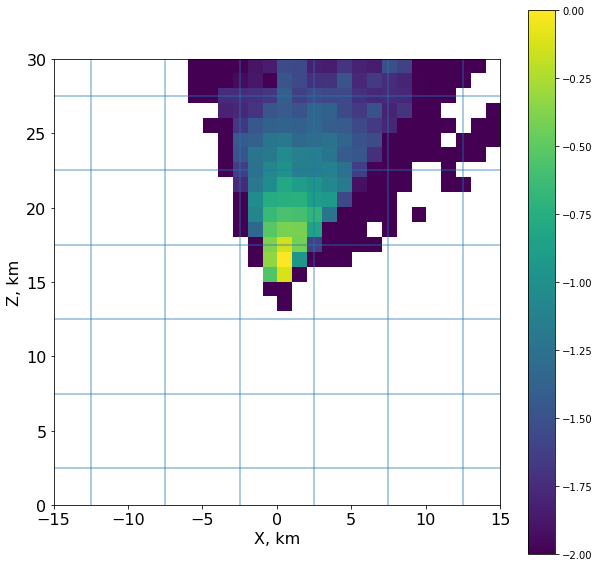

In [880]:
plt.figure(figsize=(10,10))
plt.xlim(-Rmax,Rmax)
plt.ylim(0,Hmax)
plt.xlabel('X, km',fontsize=16)
plt.ylabel('Z, km',fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)



print(np.amax(im),np.amin(im))
for i in range(-20,20):
    plt.axhline(5*i+2.5,alpha=0.5)
for i in range(-20,20):
    plt.axvline(5*i+2.5,alpha=0.5)


plt.imshow(log10(im/np.amax(im)),origin='lower',extent=[-Rmax,Rmax,0,Hmax],vmin=-2,vmax=0)
#plt.imshow(im/np.amax(im),origin='lower',extent=[-Rmax,Rmax,0,Hmax],vmin=0.01,vmax=1)

plt.colorbar(alpha=1)

plt.savefig('TGF.png',format='png',dpi=100)

14963611728.302252 0.0


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10


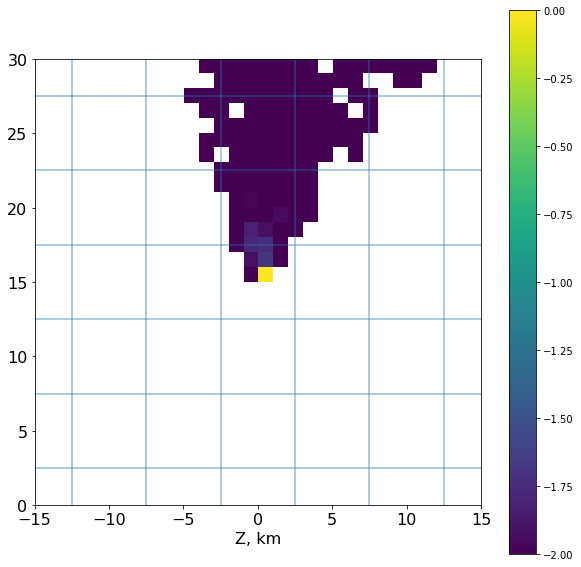

In [881]:
plt.figure(figsize=(10,10))
plt.xlim(-Rmax,Rmax)
plt.ylim(0,Hmax)
plt.xlabel('X, km',fontsize=16)
plt.xlabel('Z, km',fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)



print(np.amax(im_gamma),np.amin(im_gamma))
for i in range(-20,20):
    plt.axhline(5*i+2.5,alpha=0.5)
for i in range(-20,20):
    plt.axvline(5*i+2.5,alpha=0.5)


plt.imshow(log10(im_gamma/np.amax(im_gamma)),origin='lower',extent=[-Rmax,Rmax,0,Hmax],vmin=-2,vmax=0)
plt.colorbar(alpha=1)



13420055.162563354 0.0


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':


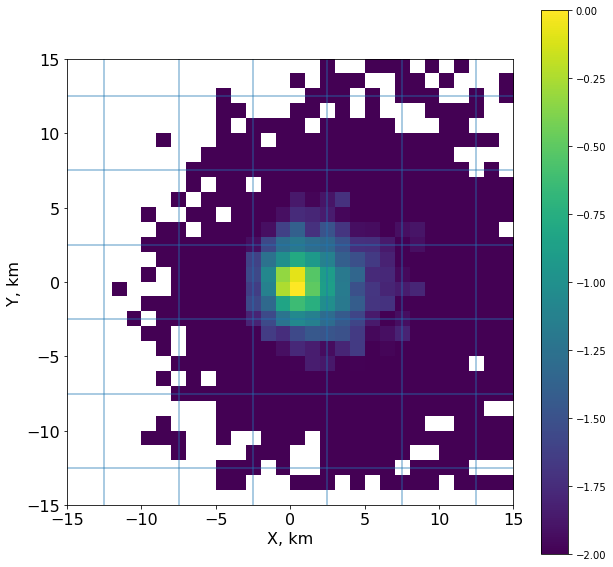

In [883]:
plt.figure(figsize=(10,10))
plt.xlim(-Rmax,Rmax)
plt.ylim(-Rmax,Rmax)
plt.xlabel('X, km',fontsize=16)
plt.ylabel('Y, km',fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)



print(np.amax(imxy),np.amin(im))

plt.imshow(log10(imxy/np.amax(imxy)),origin='lower',extent=[-Rmax,Rmax,-Rmax,Rmax],vmin=-2,vmax=0)
#plt.imshow((imxy/np.amax(imxy)),origin='lower',extent=[-Rmax,Rmax,-Rmax,Rmax],vmin=0,vmax=1)


for i in range(-10,10):
    plt.axhline(5*i+2.5,alpha=0.5)
for i in range(-10,10):
    plt.axvline(5*i+2.5,alpha=0.5)
plt.colorbar()

plt.savefig('TGF_XY.png',format='png',dpi=100)

15062203366.542706 0.0


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':


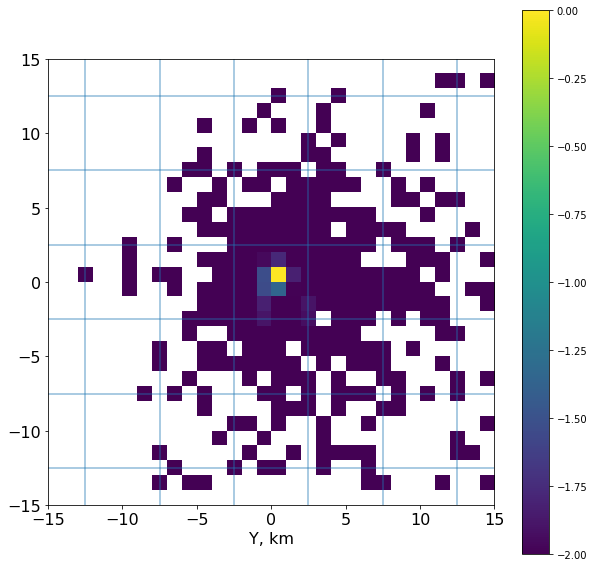

In [884]:
plt.figure(figsize=(10,10))
plt.xlim(-Rmax,Rmax)
plt.ylim(-Rmax,Rmax)
plt.xlabel('X, km',fontsize=16)
plt.xlabel('Y, km',fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)



print(np.amax(imxy_gamma),np.amin(im_gamma))

plt.imshow(log10(imxy_gamma/np.amax(imxy_gamma)),origin='lower',extent=[-Rmax,Rmax,-Rmax,Rmax],vmin=-2,vmax=0)
#plt.imshow((imxy_gamma/np.amax(imxy_gamma)),origin='lower',extent=[-Rmax,Rmax,-Rmax,Rmax],vmin=0,vmax=1)


for i in range(-10,10):
    plt.axhline(5*i+2.5,alpha=0.5)
for i in range(-10,10):
    plt.axvline(5*i+2.5,alpha=0.5)
plt.colorbar()



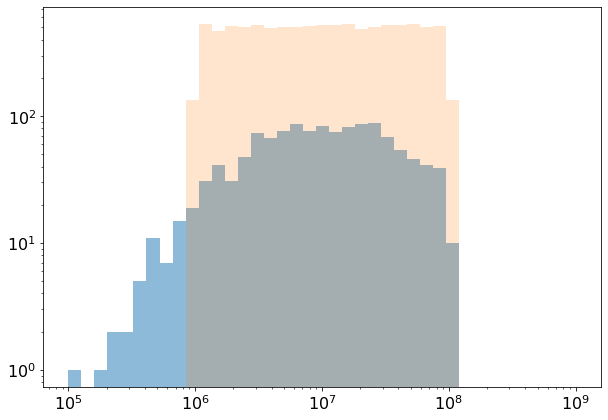

In [885]:
plt.figure(figsize=(10,7))

plt.hist(E_TGF,bins=np.logspace(5,9,40),alpha=0.5)

plt.hist(E_gamma[:,0,0],bins=np.logspace(5,9,40),alpha=0.2)

plt.xscale('log')
plt.yscale('log')
E_tot=sum(E_gamma[:,0,0])
plt.tick_params(axis='both', which='major', labelsize=16)




0.0024668984001930557 0.001586397571085335


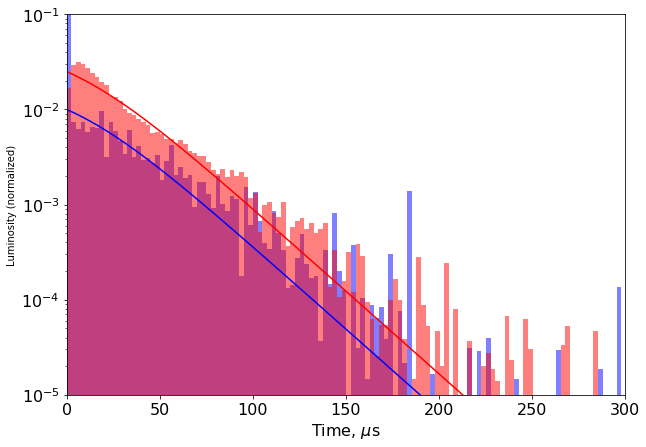

In [886]:
plt.figure(figsize=(10,7))


tmax=np.amax(T_TGF)
tmax1=np.amax(T_FL)
print(tmax,tmax1)
plt.hist(np.array(T_TGF)*1e6,weights=E_TGF,bins=np.linspace(0,1000,400),density='yes',alpha=0.5,color='blue')
plt.hist(np.array(T_FL)*1e6,weights=E_FL,bins=np.linspace(0,1000,400),density='yes',alpha=0.5,color='red')

xx=np.logspace(0,3,100)
yy=0.02/(1+exp(xx/25))
plt.plot(xx,yy,color='blue')
yy=0.05/(1+exp(xx/25))
plt.plot(xx,yy,color='red')

plt.yscale('log')
plt.ylim(1e-5,0.1)
plt.xlim(0,300)
plt.xlabel('Time, $\mu$s',fontsize=16)
plt.ylabel('Luminosity (normalized)')
plt.tick_params(axis='both', which='major', labelsize=16)
plt.savefig('LC.png',format='png',dpi=100)



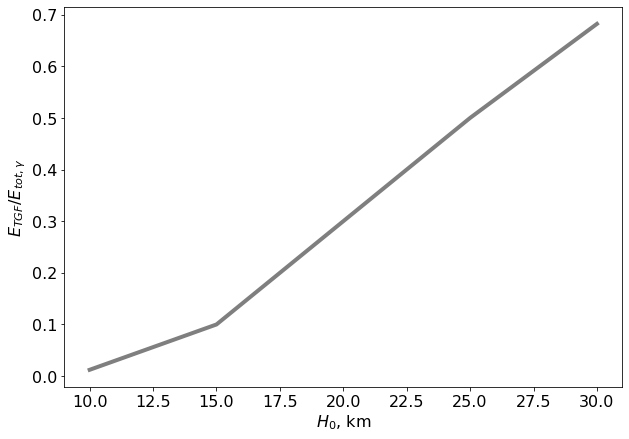

In [834]:
plt.figure(figsize=(10,7))

h=[10,15,20,25,30]
frac=[0.012201300251582607,0.1,0.3,0.5,0.6821107575179296]
plt.plot(h,frac,color='black',linewidth=4,alpha=0.5)

plt.xlabel('$H_0$, km',fontsize=16)
plt.ylabel('$E_{TGF}/E_{tot,\gamma}$',fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.savefig('TGF_fraction.png',format='png',dpi=100)


